## Bernstein–Vazirani algorithm

In [1]:
# initialization
from random import randint
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble
# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
# Number of qubits used to represent the binary string s
n = 4 # number of qubits used to represent s
# Generate a random integer between 0 and 2^n - 1 (inclusive) to 
# represent the hidden binary string
s = randint(0, 2**n - 1)   # the hidden binary string
# Format the integer s as a binary string with n bits, padding with 
# leading zeros if necessary
s = format(s, '0'+str(n)+'b')
print(s)

0101


In [3]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to.
bv_circuit = QuantumCircuit(n+1, n)
# Put ancilla qubit in a superposition state |->
bv_circuit.h(n)
bv_circuit.z(n)
# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)    
# Apply barrier to visually separate sections of the circuit
bv_circuit.barrier()
# Apply the oracle
# Below line of code performs bit reversal to adjust for Qiskit's 
# qubit ordering, which is in reverse order from the classical left-
# to-right representation. This ensures that the qubit states are 
# correctly aligned with Qiskit's indexing.
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)        
# Apply barrier to visually separate sections of the circuit
bv_circuit.barrier()
# Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)
# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

## On Simulator

In [4]:
sim = Aer.get_backend('aer_simulator')
# we need to mMake a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
bv_circuit_sim = bv_circuit.copy()
bv_circuit_sim.save_statevector()
qobj = assemble(bv_circuit_sim)

In [5]:
result = sim.run(qobj).result()

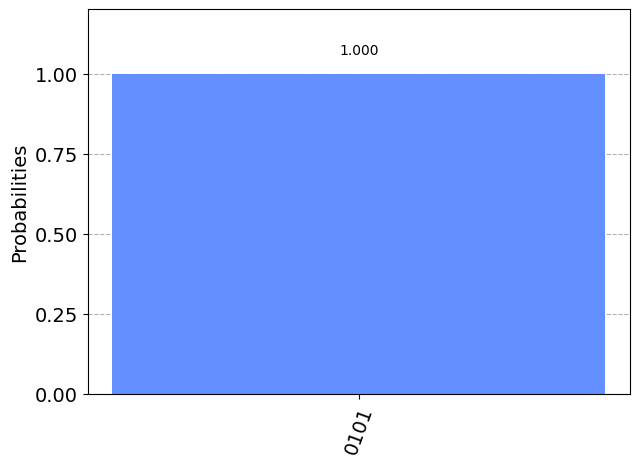

In [6]:
counts = result.get_counts()
plot_histogram(counts)

## On Real IBM quantum device

In [ ]:
# Load the IBM Quantum account for access to the available resources
IBMQ.load_account()
# Retrieve the IBM Quantum provider for the specified hub
provider = IBMQ.get_provider(hub='ibm-q')
# Find the least busy backend that can accommodate the required 
# number of qubits (n+1)
backend = least_busy(provider.backends(filters=lambda x:   
    x.configuration().n_qubits >= (n+1) and
    not x.configuration().simulator and 
    x.status().operational==True))
print("least busy backend: ", backend)

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of 
# the job in the queue
from qiskit.tools.monitor import job_monitor
# Define the number of times circuit will be run
shots = 1024
# Transpile the circuit for the specified backend with the highest 
# optimization level
transpiled_bv_circuit = transpile(bv_circuit, backend)
# Execute the transpiled circuit on the backend
job = backend.run(transpiled_bv_circuit, shots=shots)
# Monitor the job status at 2-second intervals
job_monitor(job, interval=2)

In [ ]:
# Get the results of the computation
results = job.result()
# Retrieve the counts of measurement outcomes
answer = results.get_counts()
# Plot a histogram of the measurement results
plot_histogram(answer)